In [344]:
import numpy as np
import pandas as pd

from itertools import product

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline

from geo_clustering_lib import PandasFeatureUnion

import catboost as cb
from sklearn.linear_model import LinearRegression

import mlflow
import pickle as pkl

from catboost import CatBoostRegressor

In [311]:
mlflow.set_tracking_uri('databricks')

[<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/3722490234642255', experiment_id='3722490234642255', lifecycle_stage='active', name='/Users/vasily@snoonu.com/test_experiment', tags={'mlflow.experiment.sourceName': '/Users/vasily@snoonu.com/test_experiment',
  'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
  'mlflow.ownerEmail': 'vasily@snoonu.com',
  'mlflow.ownerId': '753642737580961'}>,
 <Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/93f280934f084ebbb4581d74f9b7b8e2', experiment_id='93f280934f084ebbb4581d74f9b7b8e2', lifecycle_stage='active', name='/Repos/vasily@snoonu.com/databricks-working-notebooks/examples/mlflow_test', tags={'mlflow.experiment.sourceId': '3980483836470831',
  'mlflow.experiment.sourceName': '/Repos/vasily@snoonu.com/databricks-working-notebooks/examples/mlflow_test',
  'mlflow.experiment.sourceType': 'REPO_NOTEBOOK',
  'mlflow.ownerEmail': 'vasily@snoonu.com',
  'mlflow.ownerId': '753642737580961'}>]

In [192]:
df = pd.read_pickle('data.pkl')

In [378]:
QATAR_DOW_TYPE = {
    0: 'weekday',
    1: 'weekday',
    2: 'weekday',
    3: 'thursday',
    4: 'weekend',
    5: 'weekend',
    6: 'weekday'
}

class TimeAggregator(BaseEstimator, TransformerMixin):
    def __init__(self, interval='5T', time_column='PickupByUtc', agg_func='size',
                 start_date=None, end_date=None, res_column='orders_cnt'):
        self.interval = interval
        self.time_column = time_column
        self.agg_func = agg_func
        self.start_date = start_date
        self.end_date = end_date
        self.res_column = res_column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        print(self.__class__)
        # print(self.__class__, y)
        start_date = self.start_date or X[self.time_column].min().floor('D')
        end_date = self.end_date or X[self.time_column].max().ceil('D') - pd.to_timedelta(self.interval)

        new_index = pd.date_range(
            start=start_date,
            end=end_date,
            freq=self.interval
        )

        tmp = X.resample(self.interval, on=self.time_column) \
                .agg(self.agg_func) \
                .rename(self.res_column) \
                .reindex(new_index, fill_value=0) \
                .reset_index() \
                .rename(columns={'index': self.time_column})
        return tmp


class LagFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, offsets, interval, time_col='PickupByUtc',
                 column_name='orders_cnt', static_offset=None):
        self.offsets = offsets
        self.time_col = time_col
        self.column_name = column_name
        self.static_offset = static_offset

        self.interval = self._validate_data_interval(interval)
        self.static_offset = self._validate_data_interval(static_offset)

    def _validate_data_interval(self, interval):
        if interval is None:
            return '0D'
        if not interval[0].isnumeric():
            return '1' + interval
        else:
            return interval

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        print(self.__class__)
        # print(self.__class__, y)
        features = {}
        val_dict = X.set_index(self.time_col)[self.column_name].to_dict()
        interval_td = pd.to_timedelta(self.interval)
        static_offset_td = pd.to_timedelta(self.static_offset)
        for offset in self.offsets:
            # assert offset > 0, 'We cant look into future'
            offset_time = (X[self.time_col] - interval_td * offset - static_offset_td)
            features[f'lag_{self.interval}_x{offset}_+{self.static_offset}'] = offset_time.map(val_dict)
        
        # print(features.keys())
        return pd.DataFrame(features) # .drop(self.time_col, axis=1)

class TimeFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, time_col='PickupByUtc'):
        self.time_col = time_col

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        print(self.__class__)
        features = {}
        time_col = X[self.time_col].copy()
        features['day_of_week'] = time_col.dt.dayofweek
        features['dow_type'] = features['day_of_week'].map(QATAR_DOW_TYPE).astype('category').cat.codes
        features['time'] = time_col.dt.hour / 24 + time_col.dt.minute / 60 / 24
        features['hour'] = time_col.dt.hour / 24
        
        return pd.DataFrame(features)

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        if isinstance(cols, str):
            cols = [cols]
        self.cols = cols
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        print(self.__class__)
        return X[self.cols]

class ColumnDeleter(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        if isinstance(cols, str):
            cols = [cols]
        self.cols = cols
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        print(self.__class__)
        return X.drop(self.cols, axis=1)

class HackyModel(BaseEstimator, RegressorMixin):
    def __init__(self, model, target_col='orders_cnt'):
        self.model = model
        self.target_col = target_col
    def fit(self,X, y=None):
        self.X_ = X.drop(self.target_col, axis=1)
        self.y_ = X[self.target_col]
        # Return the classifier
        return self.model.fit(self.X_, self.y_)

    def predict(self, X):
        return self.model.predict(X.X)

class Filler(BaseEstimator, TransformerMixin):
    def __init__(self, value=0):
        self.value = value
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        print(self.__class__)
        return X.fillna(0)

class MyRegressor(BaseEstimator):
    def __init__(self, model, target):
        self.model = model
        self.target = target
    
    def fit(self, X, y=None):
        print(X.columns)
        self.model.fit(X.drop(self.target, axis=1), X[self.target])
        return self

    def transform(self, X, y=None):
        return X

    def predict(self, X):
        if self.target in X:
            preds = self.model.predict(X.drop(self.target, axis=1))
        else:
            preds = self.model.predict(X)
        return preds

class GroupByPredictor(BaseEstimator):
    def __init__(self, groupby, model, target):
        self.groupby = groupby
        self.model = model
        self.target = target
        self.fitted_models = {}

    def predict(self, X):
        if not self.fitted_models:
            raise Exception('Predictor is not fitted')
        
        results = []
        for group_name, group_df in X.groupby(self.groupby):
            if group_name not in self.fitted_models:
                raise Exception(f'Group {group_name} is not present in train data')
            pred = self.fitted_models[group_name].predict(group_df)
            results.append(pd.Series(data=pred, index=group_df.index))
        return pd.concat(results)[X.index].values

    def fit(self, X, y=None):
        self.fitted_models = {}
        if (self.groupby not in X) or (self.target not in X):
            print(f'{self.target} or {self.groupby} is not in the data')
        
        for group_name, group_df in X.groupby(self.groupby):
            self.fitted_models[group_name] = self.model()
            self.fitted_models[group_name].fit(
                group_df.drop(self.target, axis=1),
                group_df[self.target]
            )

class PandasGridSearch(BaseEstimator, TransformerMixin):
    def __init__(self, estimator, param_grid, target, scoring, additional_metrics=None, cv=5, log_mlflow=False):
        self.param_grid = param_grid
        self.estimator = estimator
        self.best_estimator = None
        self.target = target
        self.scoring = scoring
        self.additional_metrics = additional_metrics or []
        self.param_names = list(self.param_grid.keys())
        self.log_mlflow = log_mlflow

        if isinstance(cv, int):
            self.cv = KFold(cv, shuffle=True)
        else:
            self.cv = cv

    def _run_single_set(self, params, X):
        new_estimator = clone(self.estimator)
        new_estimator.set_params(**params)

        transformed_X = new_estimator.fit_transform(X)
        predictor = new_estimator[-1]

        scores, additional_metrics_ = [], []
        for train_idx, test_idx in self.cv.split(transformed_X):
            predictor.fit(
                transformed_X.iloc[train_idx]
            )
            preds = predictor.predict(transformed_X.iloc[test_idx])
            fold_score = self.scoring(transformed_X.iloc[test_idx][self.target], preds)
            print((transformed_X.iloc[test_idx][self.target] == 0).mean())
            scores.append(fold_score)
            additional_metrics_.append([
                m(transformed_X.iloc[test_idx][self.target], preds) 
                for m in self.additional_metrics]
                )
        
        score = np.mean(scores)
        additional_metrics = np.mean(additional_metrics_, axis=0)
        return new_estimator, score, additional_metrics

    def fit(self, X, y=None):
        if self.log_mlflow:
            mlflow_client = mlflow.tracking.MlflowClient()
            experiment = mlflow_client.get_experiment_by_name(self.log_mlflow)
            if experiment is None:
                experiment = mlflow_client.create_experiment(self.log_mlflow)
            else:
                experiment = experiment.experiment_id
            mlflow.set_experiment(experiment_id=experiment)

        self.scores = {}
        best_score, best_model = None, None
        p_list = [self.param_grid[p] for p in self.param_names]
        for params in product(*p_list):
            params_dict = {p:v for p, v in zip(self.param_names, params)}
            print(params, params_dict)
            model, score, metrics = self._run_single_set(params_dict, X)
            if self.log_mlflow:
                with mlflow.start_run():
                    mlflow.log_params(params_dict)
                    pkl.dump(model, open('model.pkl', 'wb'))
                    mlflow.log_artifact('model.pkl')
                    mlflow.log_metric(self.scoring.__name__, score)
                    if self.additional_metrics:
                        mlflow.log_metrics({k.__name__:v for k, v in zip(self.additional_metrics, metrics)})

            print(params, score)
            # self.scores[tuple(params)] = (score)
            if (best_score is None) or (best_score < score):
                best_score = score
                best_model = model
        
        self.best_score = best_score
        self.best_model = best_model
        return self
    


In [377]:
df[mask]['PickupByUtc'].max().ceil('D') - pd.to_timedelta('5T')

Timestamp('2022-05-31 23:55:00+0000', tz='UTC')

In [373]:
pipeline[0].fit_transform(df[mask])

<class '__main__.TimeAggregator'>


PickupByUtc  orders_cnt
0   2022-05-01 00:00:00+00:00         282
1   2022-05-01 06:00:00+00:00        1608
2   2022-05-01 12:00:00+00:00        4876
3   2022-05-01 18:00:00+00:00        4633
4   2022-05-02 00:00:00+00:00        1112
..                        ...         ...
120 2022-05-31 00:00:00+00:00         821
121 2022-05-31 06:00:00+00:00        3587
122 2022-05-31 12:00:00+00:00        5568
123 2022-05-31 18:00:00+00:00        3312
124 2022-06-01 00:00:00+00:00           0

[125 rows x 2 columns]

In [371]:
mask = df['PickupByUtc'] < '2022-06-01'

In [320]:
cl = mlflow.tracking.MlflowClient()
cl.create_experiment('/Users/vasily@snoonu.com/another_experiment')

RestException: RESOURCE_ALREADY_EXISTS: Node named 'another_experiment' already exists

In [324]:
cl.get_experiment_by_name('/Users/vasily@snoonu.com/another_experiment').experiment_id

'198801628904460'

In [390]:
AGG_INTERVAL = '60T'

features_pipe = PandasFeatureUnion([
    ('prev_day', LagFeatures([1, 2, 3], AGG_INTERVAL, static_offset='D')),
    ('prev2_day',    LagFeatures([1, 2, 3], AGG_INTERVAL, static_offset='2D')),
    ('prev3_day',    LagFeatures([1, 2, 3], AGG_INTERVAL, static_offset='3D')),
    ('daily_lag',    LagFeatures([1, 2, 3, 4, 5, 6, 7], 'D')),
    ('time_feat',    TimeFeatures()),
    ('add_target', ColumnSelector('orders_cnt')),
    # ('del_timestamp', ColumnDeleter('PickupByUtc')),
    ('add_pickup_time', ColumnSelector('PickupByUtc'))
])

pipeline = Pipeline([
    ('aggregation', TimeAggregator(AGG_INTERVAL)),
    ('features', features_pipe),
    ('del_timestamp', ColumnDeleter('PickupByUtc')),
    ('fill_na', Filler(0)),
    ('regression', MyRegressor(CatBoostRegressor(), 'orders_cnt'))
])

In [391]:
param_grid = {
    'features__prev_day__offsets': [set([1]), set([1, 2]), set([1, 2, 3]), set([1, 2, 3, 4]), set([1, 2, 3, 4, 5])],
    'features__prev2_day__offsets': [set([1]), set([1, 2]), set([1, 2, 3]), set([1, 2, 3, 4]), set([1, 2, 3, 4, 5])],
    'features__prev3_day__offsets': [set([1]), set([1, 2]), set([1, 2, 3]), set([1, 2, 3, 4]), set([1, 2, 3, 4, 5])],
    'features__daily_lag__offsets': [set([1, 2, 3, 4, 5, 6, 7]), set([1, 2, 3, 4, 5, 6, 7, 8, 9])],
}

def neg_mae(true, pred):
    return - mean_absolute_error(true, pred)

pgs = PandasGridSearch(
    pipeline, param_grid, cv=KFold(5),
    target='orders_cnt',
    scoring=neg_mae,
    additional_metrics=[mean_absolute_percentage_error, mean_squared_error],
    log_mlflow='/Users/vasily@snoonu.com/test_exp_1'
)

pgs.fit(df[mask])
pgs.best_score, pgs.best_model

({1}, {1}, {1}, {1, 2, 3, 4, 5, 6, 7}) {'features__prev_day__offsets': {1}, 'features__prev2_day__offsets': {1}, 'features__prev3_day__offsets': {1}, 'features__daily_lag__offsets': {1, 2, 3, 4, 5, 6, 7}}
<class '__main__.TimeAggregator'>
<class '__main__.LagFeatures'>
<class '__main__.LagFeatures'>
<class '__main__.LagFeatures'>
<class '__main__.LagFeatures'>
<class '__main__.TimeFeatures'>
<class '__main__.ColumnSelector'>
<class '__main__.ColumnSelector'>
<class '__main__.ColumnDeleter'>
<class '__main__.Filler'>
Index(['lag_60T_x1_+1D', 'lag_60T_x1_+2D', 'lag_60T_x1_+3D', 'lag_1D_x1_+0D',
       'lag_1D_x2_+0D', 'lag_1D_x3_+0D', 'lag_1D_x4_+0D', 'lag_1D_x5_+0D',
       'lag_1D_x6_+0D', 'lag_1D_x7_+0D', 'day_of_week', 'dow_type', 'time',
       'hour', 'orders_cnt'],
      dtype='object')
Learning rate set to 0.039074
0:	learn: 351.4876418	total: 986us	remaining: 985ms
1:	learn: 341.0478123	total: 1.92ms	remaining: 959ms
2:	learn: 330.8320986	total: 2.92ms	remaining: 971ms
3:	learn:

In [302]:
tuple(0, )

TypeError: 'int' object is not iterable

In [282]:
from sklearn.model_selection import GridSearchCV

In [290]:
PandasGridSearch(pipeline, {'fill_na__value': [0, 1]}, scoring='neg_mean_absolute_percentage_error').fit(df, 1)

Index(['lag_15T_x1_+1D', 'lag_15T_x2_+1D', 'lag_15T_x3_+1D', 'lag_1D_x1_+0D',
       'lag_1D_x2_+0D', 'lag_1D_x3_+0D', 'lag_1D_x4_+0D', 'lag_1D_x5_+0D',
       'lag_1D_x6_+0D', 'lag_1D_x7_+0D', 'day_of_week', 'dow_type', 'time',
       'hour', 'orders_cnt'],
      dtype='object')


/Users/vasikos/.pyenv/versions/py3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vasikos/.pyenv/versions/py3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 759, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


Index(['lag_15T_x1_+1D', 'lag_15T_x2_+1D', 'lag_15T_x3_+1D', 'lag_1D_x1_+0D',
       'lag_1D_x2_+0D', 'lag_1D_x3_+0D', 'lag_1D_x4_+0D', 'lag_1D_x5_+0D',
       'lag_1D_x6_+0D', 'lag_1D_x7_+0D', 'day_of_week', 'dow_type', 'time',
       'hour', 'orders_cnt'],
      dtype='object')


/Users/vasikos/.pyenv/versions/py3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vasikos/.pyenv/versions/py3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 759, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


Index(['lag_15T_x1_+1D', 'lag_15T_x2_+1D', 'lag_15T_x3_+1D', 'lag_1D_x1_+0D',
       'lag_1D_x2_+0D', 'lag_1D_x3_+0D', 'lag_1D_x4_+0D', 'lag_1D_x5_+0D',
       'lag_1D_x6_+0D', 'lag_1D_x7_+0D', 'day_of_week', 'dow_type', 'time',
       'hour', 'orders_cnt'],
      dtype='object')


/Users/vasikos/.pyenv/versions/py3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vasikos/.pyenv/versions/py3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 759, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


Index(['lag_15T_x1_+1D', 'lag_15T_x2_+1D', 'lag_15T_x3_+1D', 'lag_1D_x1_+0D',
       'lag_1D_x2_+0D', 'lag_1D_x3_+0D', 'lag_1D_x4_+0D', 'lag_1D_x5_+0D',
       'lag_1D_x6_+0D', 'lag_1D_x7_+0D', 'day_of_week', 'dow_type', 'time',
       'hour', 'orders_cnt'],
      dtype='object')


/Users/vasikos/.pyenv/versions/py3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vasikos/.pyenv/versions/py3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 759, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


Index(['lag_15T_x1_+1D', 'lag_15T_x2_+1D', 'lag_15T_x3_+1D', 'lag_1D_x1_+0D',
       'lag_1D_x2_+0D', 'lag_1D_x3_+0D', 'lag_1D_x4_+0D', 'lag_1D_x5_+0D',
       'lag_1D_x6_+0D', 'lag_1D_x7_+0D', 'day_of_week', 'dow_type', 'time',
       'hour', 'orders_cnt'],
      dtype='object')


/Users/vasikos/.pyenv/versions/py3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vasikos/.pyenv/versions/py3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 759, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


Index(['lag_15T_x1_+1D', 'lag_15T_x2_+1D', 'lag_15T_x3_+1D', 'lag_1D_x1_+0D',
       'lag_1D_x2_+0D', 'lag_1D_x3_+0D', 'lag_1D_x4_+0D', 'lag_1D_x5_+0D',
       'lag_1D_x6_+0D', 'lag_1D_x7_+0D', 'day_of_week', 'dow_type', 'time',
       'hour', 'orders_cnt'],
      dtype='object')


/Users/vasikos/.pyenv/versions/py3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vasikos/.pyenv/versions/py3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 759, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


Index(['lag_15T_x1_+1D', 'lag_15T_x2_+1D', 'lag_15T_x3_+1D', 'lag_1D_x1_+0D',
       'lag_1D_x2_+0D', 'lag_1D_x3_+0D', 'lag_1D_x4_+0D', 'lag_1D_x5_+0D',
       'lag_1D_x6_+0D', 'lag_1D_x7_+0D', 'day_of_week', 'dow_type', 'time',
       'hour', 'orders_cnt'],
      dtype='object')


/Users/vasikos/.pyenv/versions/py3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vasikos/.pyenv/versions/py3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 759, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


Index(['lag_15T_x1_+1D', 'lag_15T_x2_+1D', 'lag_15T_x3_+1D', 'lag_1D_x1_+0D',
       'lag_1D_x2_+0D', 'lag_1D_x3_+0D', 'lag_1D_x4_+0D', 'lag_1D_x5_+0D',
       'lag_1D_x6_+0D', 'lag_1D_x7_+0D', 'day_of_week', 'dow_type', 'time',
       'hour', 'orders_cnt'],
      dtype='object')


/Users/vasikos/.pyenv/versions/py3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vasikos/.pyenv/versions/py3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 759, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


Index(['lag_15T_x1_+1D', 'lag_15T_x2_+1D', 'lag_15T_x3_+1D', 'lag_1D_x1_+0D',
       'lag_1D_x2_+0D', 'lag_1D_x3_+0D', 'lag_1D_x4_+0D', 'lag_1D_x5_+0D',
       'lag_1D_x6_+0D', 'lag_1D_x7_+0D', 'day_of_week', 'dow_type', 'time',
       'hour', 'orders_cnt'],
      dtype='object')


/Users/vasikos/.pyenv/versions/py3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vasikos/.pyenv/versions/py3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 759, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


Index(['lag_15T_x1_+1D', 'lag_15T_x2_+1D', 'lag_15T_x3_+1D', 'lag_1D_x1_+0D',
       'lag_1D_x2_+0D', 'lag_1D_x3_+0D', 'lag_1D_x4_+0D', 'lag_1D_x5_+0D',
       'lag_1D_x6_+0D', 'lag_1D_x7_+0D', 'day_of_week', 'dow_type', 'time',
       'hour', 'orders_cnt'],
      dtype='object')


/Users/vasikos/.pyenv/versions/py3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/vasikos/.pyenv/versions/py3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 759, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/Users/vasikos/.pyenv/versions/py3.10/lib/python3.10/site-packages/sklearn/model_selection/_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan]
  warnings.warn(


Index(['lag_15T_x1_+1D', 'lag_15T_x2_+1D', 'lag_15T_x3_+1D', 'lag_1D_x1_+0D',
       'lag_1D_x2_+0D', 'lag_1D_x3_+0D', 'lag_1D_x4_+0D', 'lag_1D_x5_+0D',
       'lag_1D_x6_+0D', 'lag_1D_x7_+0D', 'day_of_week', 'dow_type', 'time',
       'hour', 'orders_cnt'],
      dtype='object')


GridSearchCV(estimator=Pipeline(steps=[('aggregation',
                                        TimeAggregator(interval='15T')),
                                       ('features',
                                        PandasFeatureUnion(transformer_list=[('interval_lag',
                                                                              LagFeatures(interval='15T',
                                                                                          offsets=[1,
                                                                                                   2,
                                                                                                   3],
                                                                                          static_offset='1D')),
                                                                             ('daily_lag',
                                                                              LagFeatures(interval='1D',
     

In [288]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [213]:
def train_evaluate_catboost(data, pipeline, model, agg_interval='15T'):

    features_pipe = PandasFeatureUnion([
        ('interval_lag', LagFeatures([-2, -1, 1, 2, 3, 4, 5], agg_interval, static_offset='D')),
        ('daily_lag',    LagFeatures([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'D')),
        ('aggregate',    TimeFeatures()),
        ('add_target', ColumnSelector('orders_cnt')),
        ('add_pickup_time', ColumnSelector('PickupByUtc'))
    ])

    pipeline = Pipeline([
        ('aggregation', TimeAggregator(agg_interval)),
        ('features', features_pipe),
        # ('add_target', ColumnDeleter('pickupByUtc')),
    ])

    transformed = pipeline.fit_transform(data)

    transformed_rush_mask = (transformed['PickupByUtc'].dt.hour >= 9) & (transformed['PickupByUtc'].dt.hour <= 21)

    train_data, test_data = train_test_split(transformed[transformed_rush_mask], train_size=.8, random_state=17)

    cbr = cb.CatBoostRegressor(silent=True)
    model.fit(train_data.drop(['orders_cnt', 'PickupByUtc'], axis=1), train_data['orders_cnt'],
                cat_features=['dow_type', 'day_of_week'])

    preds = model.predict(test_data.drop(['orders_cnt', 'PickupByUtc'], axis=1))

    mse = mean_squared_error(test_data['orders_cnt'], preds)
    mae = mean_absolute_error(test_data['orders_cnt'], preds)
    mape = mean_absolute_percentage_error(test_data['orders_cnt'], preds)

    return mse, mae, mape, preds, test_data['orders_cnt']

mse, mae, mape, c, d = train_evaluate_catboost(df, pipeline, cb.CatBoostRegressor(silent=True), agg_interval='60T')

In [214]:
mae

93.96267186630948

In [215]:
mape

5.007697252288301e+16

In [139]:
mask = d > 10
mean_absolute_percentage_error(d[mask], c[mask])

0.1847628036850972

In [208]:
df.groupby(df['PickupByUtc'].dt.hour).size()

PickupByUtc
0.0      5191
1.0      3810
2.0      4170
3.0      5184
4.0      9252
5.0     14410
6.0     16971
7.0     19756
8.0     24384
9.0     33886
10.0    35688
11.0    36882
12.0    35108
13.0    38386
14.0    43183
15.0    44595
16.0    55014
17.0    59123
18.0    56634
19.0    46351
20.0    33848
21.0    21223
22.0    14532
23.0     9176
dtype: int64

In [141]:
import mlflow

In [142]:
client = mlflow.tracking.MlflowClient()

In [145]:
exp = client.get_experiment_by_name('Demand clustering')

In [146]:
client.list_artifacts()

TypeError: MlflowClient.list_artifacts() missing 1 required positional argument: 'run_id'

In [150]:
candidate_runs = ['8db1807dc4c5420e9903a534249d7815', '7e61e947ca1c42b6a72cb1b1b8df781b', '28704a6b0d58431e8c8d62aed8e2681b']
run = client.get_run('8db1807dc4c5420e9903a534249d7815')

In [155]:
client.list_artifacts('28704a6b0d58431e8c8d62aed8e2681b')[0].path

'clisters.pkl'

In [156]:
import pickle as pkl

In [163]:
run_id = candidate_runs[0]
file_path = f'./mlruns/1/{run_id}/artifacts/clisters.pkl'

with open(file_path, 'rb') as file:
    clusters = pkl.load(file)


In [170]:
mask1 = ((df['PickupByUtc'] >= '2022-05-01') & (df['PickupByUtc'] < '2022-06-01') & df[['PickupLatitude', 'PickupLongitude']].notna().all(axis=1))
dfm = df[mask1]

In [216]:
res = {'mae':[], 'mse':[], 'mape':[]}
for name, df_ in dfm.groupby(clusters):

    if name == -1:
        print('others')
    else:
        mse, mae, mape, preds, true = train_evaluate_catboost(df_, pipeline, cb.CatBoostRegressor(silent=True), agg_interval='60T')
        res['mae'].append(mae)
        res['mse'].append(mse)
        res['mape'].append(mean_absolute_percentage_error(true, preds))

print(
    sum(res['mae']) / len(res['mae']),
    sum(res['mse']) / len(res['mse']),
    sum(res['mape']) / len(res['mape']),
)

others
2.5519234066503227 12.456722880613217 0.3589542313413098


<AxesSubplot:>

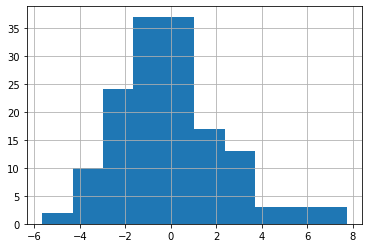

In [194]:
(true - preds).hist()

In [181]:
0.9109387798380887 1.804968933753948 0.5982043347506525

[0.6669324646834934,
 0.8408304357548537,
 0.743111116087058,
 1.2475482913084304,
 0.7785755458364775,
 0.9700676177558231,
 0.7514062816569539,
 0.6544634050179567,
 0.9116725546714911,
 0.7874058553408386,
 1.025192933106424,
 0.675974686509338,
 1.8378016831876738,
 0.9790911009343949,
 0.7636436668895611,
 0.8693765536049483,
 0.6542479626621647,
 0.72522392765484,
 1.7961487422372657,
 0.7038578552183334,
 0.9242896886765732,
 0.7187125430079587,
 0.7607073805545309,
 1.4293248474449545,
 0.7548852942189119,
 0.7637236935637033,
 0.8318242128842536,
 0.5870682006258543,
 0.9941646624321052,
 0.711638132292992,
 0.7316159835841629,
 0.7599216851350263,
 0.7773106573248334,
 1.03697895892397,
 0.7304717488130354,
 1.3985101472597894,
 0.8530216049262527,
 0.7494012336572037,
 1.0642977763946484,
 1.6152736551883002,
 0.8174538420443933,
 0.8922353084145911,
 0.8849635955514328]